# Agriculture Detection with Keras
This notebook focuses on the TensorFlow/Keras workflow for loading satellite imagery data, batching it, and preparing it for model training.

In [185]:
# Import Required Libraries
import os
import importlib
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam

# Local imports
import utils.main_utils as main_utils
importlib.reload(main_utils)
from utils.main_utils import check_skillnetwork_extraction, shuffle_data
import utils.keras_ai_utils as keras_ai_utils
importlib.reload(keras_ai_utils)
from utils.keras_ai_utils import (
    set_tf_processing_env,
    create_keras_datasets,
    display_keras_batch,
    configure_keras_for_performance,
    keras_custom_data_generator,
    display_custom_keras_batch,
    create_generators,
    build_keras_model,
    display_keras_history,
    evaluate_keras_model
)

<!-- ## Download and Extract Data
Download the satellite images dataset and extract it to the `data/` directory if it is not already available. -->

In [177]:
# Download and extract data
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar'
extract_dir = './data/'
model_dir = './models/'
os.makedirs(extract_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
dataset_path = os.path.join(extract_dir, 'images_dataSAT')
await check_skillnetwork_extraction(extract_dir, url)

Checking write permissions for skillsnetwork extraction...
Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to 'data'


## Label and Shuffle Data
Aggregate image paths and labels for agricultural and non-agricultural classes, then shuffle for downstream batching.

In [178]:
# Label and shuffle data
base_dir = './data/images_dataSAT/'
dir_non_agri_name = os.path.join(base_dir, 'class_0_non_agri')
dir_agri_name = os.path.join(base_dir, 'class_1_agri')

all_image_paths, all_labels = shuffle_data(dir_non_agri_name, dir_agri_name)

Shuffling data...


## Custom Data Generator vs Keras Dataset

Displaying a custom data batch...
Generating custom data batches...
Images batch shape: (8, 64, 64, 3)
Labels batch shape: (8,)
Creating Keras datasets...
Found 6000 files belonging to 2 classes.
Using 4800 files for training.
Found 6000 files belonging to 2 classes.
Using 1200 files for validation.
Displaying a Keras data batch...


2025-11-06 15:17:34.128775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


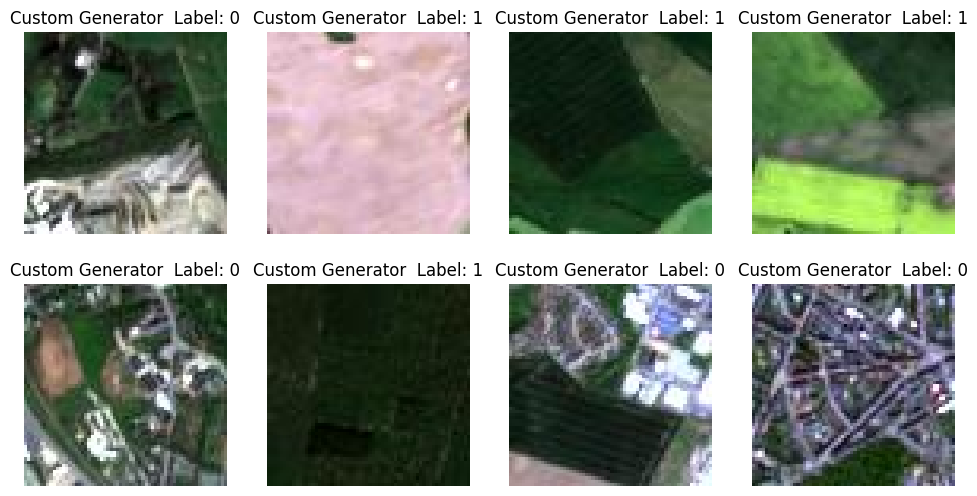

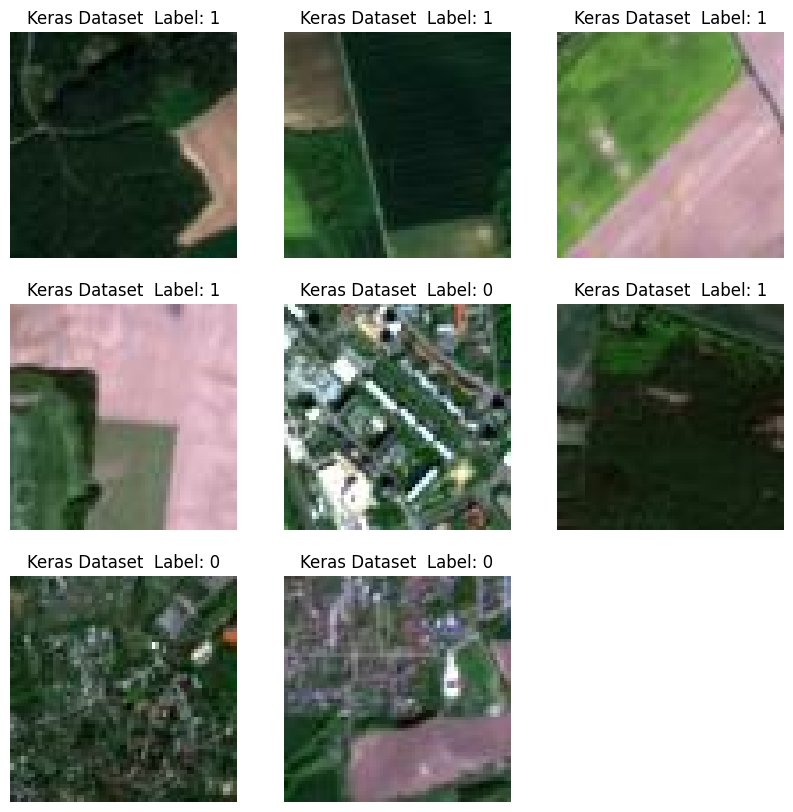

In [179]:
# Custom generator for custom batching
batch_size = 8
data_generator = keras_custom_data_generator(
    image_paths=all_image_paths,
    labels=all_labels,
    batch_size=batch_size,
)
display_custom_keras_batch(data_generator, batch_size, title='Custom Generator')

# Create and inspect Keras datasets
img_size = (64, 64)
train_ds, val_ds = create_keras_datasets(
    base_dir=base_dir,
    img_size=img_size,
    batch_size=batch_size,
)
display_keras_batch(batch_size, train_ds, title='Keras Dataset')

## Configure Keras Pipelines for Performance
Apply caching, shuffling, and prefetching strategies to optimize input pipelines.

In [180]:
# Optimize datasets for performant training
train_ds, val_ds = configure_keras_for_performance(train_ds, val_ds)

Configuring Keras datasets for performance...


## Setup Tensorflow Processing Environment

In [181]:
device, fnames = set_tf_processing_env(dataset_path)

Setting TensorFlow processing environment...
Device available for training: cpu
Setting TensorFlow random seed to 1...
Getting file names from dataset...
total files in dataset: 6000
./data/images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_5974.jpg
./data/images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_23339.jpg
./data/images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_15163.jpg
./data/images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_8291.jpg


## Define Hyperparameters

In [182]:
# Hyperparameters
img_w, img_h = 64, 64                  # Image width and height
n_channels = 3                         # Number of image channels (e.g., 3 for RGB)
batch_size = 128                       # Number of samples per gradient update
lr = .001                              # Learning rate for the optimizer
n_epochs = 3                           # Number of times to iterate over the entire dataset
steps_per_epoch = None                 # Number of steps (batches) to take for each epoch
validation_steps = None                # Number of steps (batches) to take for validation
hidden_activation = 'relu'             # Activation function for hidden layers
output_activation = 'sigmoid'          # Activation function for the output layer
padding = 'same'                       # Padding strategy for convolutional layers
strides = (1, 1)                       # Strides for convolutional layers
kernel_size = (5, 5)                   # Kernel size for convolutional layers
kernel_initializer = HeUniform()       # Initializer for the kernel weights
dropout = .4                           # Dropout rate for regularization
loss = 'binary_crossentropy'           # Loss function for the model
optimizer = Adam(learning_rate=lr)     # Optimizer for training the model
metrics = ['accuracy']                 # Metrics to monitor during training
filter_base = 32                       # Base number of filters for convolutional layers
unit_base = 128                        # Base number of units for dense layers
output_units = 1                       # Number of units in the output layer
conv_block_num = 4                     # Number of convolutional blocks
dense_block_num = 2                    # Number of dense blocks
pool_size = (2, 2)                     # Pool size for MaxPooling layers
pool_strides = (2, 2)                  # Strides for MaxPooling layers

# Data augmentation parameters
rescale = 1./255                       # Rescaling factor for pixel values
rotation_range = 40                    # Degree range for random rotations
width_shift_range = 0.2                # Fraction of total width for random horizontal shifts
height_shift_range = 0.2               # Fraction of total height for random vertical shifts
shear_range = 0.2                      # Shear intensity (shear angle in counter-clockwise direction)
zoom_range = 0.2                       # Range for random zoom
horizontal_flip = True                 # Randomly flip inputs horizontally
fill_mode = 'nearest'                  # Strategy for filling in newly created pixels
validation_split = 0.2                 # Fraction of data to reserve for validation

# Configuration parameters
model_name = os.path.join(             # Name of the file to save the model
    model_dir, 
    'keras_model.model.keras'
) 
class_mode = 'binary'                  # Type of classification problem
target_size = (img_w, img_h)           # Dimensions to which all images will be resized
tqdm_verbose = 1                       # Verbosity mode for TQDM progress bar
verbose = 0                            # Verbosity mode for model training

## Create Data Generators for Training and Validation

In [183]:
train_generator, validation_generator = create_generators(
    dataset_path,
    target_size,
    batch_size,
    class_mode,
    rescale,
    rotation_range,
    width_shift_range,
    height_shift_range,
    shear_range,
    zoom_range,
    horizontal_flip,
    fill_mode,
    validation_split
)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


## Build and Train Model

In [184]:
model, fit = build_keras_model(
    train_generator,
    validation_generator,
    optimizer,
    kernel_initializer, 
    filter_base=filter_base, 
    unit_base=unit_base, 
    output_units=output_units, 
    conv_block_num=conv_block_num,
    dense_block_num=dense_block_num,
    hidden_activation=hidden_activation, 
    padding=padding, 
    strides=strides, 
    kernel_size=kernel_size, 
    img_w=img_w, 
    img_h=img_h, 
    n_channels=n_channels, 
    dropout=dropout, 
    output_activation=output_activation,
    loss=loss,
    metrics=metrics,
    model_name=model_name,
    device=device,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    tqdm_verbose=tqdm_verbose,
    verbose=verbose,
    validation_steps=validation_steps,
    pool_size=pool_size,
    pool_strides=pool_strides
)

Building Keras model...
Training on : ===cpu=== with batch size: 128 & lr: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_accuracy improved from None to 0.56083, saving model to ./models/keras_model.model.keras

Epoch 2: val_accuracy did not improve from 0.56083

Epoch 3: val_accuracy improved from 0.56083 to 0.60667, saving model to ./models/keras_model.model.keras


## Display Results

In [ ]:
display_keras_history(validation_generator, model, fit)

## Display Metrics

Evaluating Keras model...


/Users/isaacdavis/Desktop/PersonalStuff/MyProjects/GitHub/AI/agriculture_detection/env/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/st ━━━━━━━━━

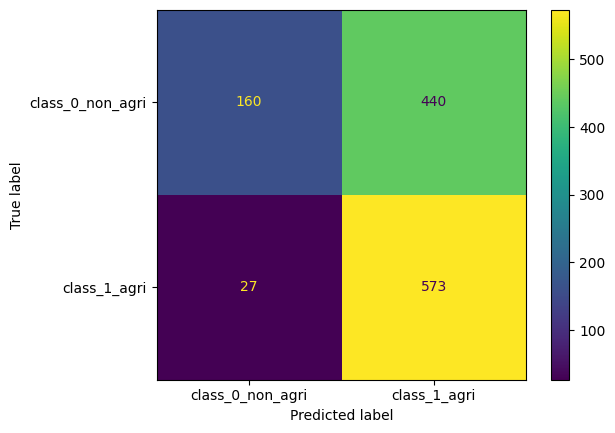

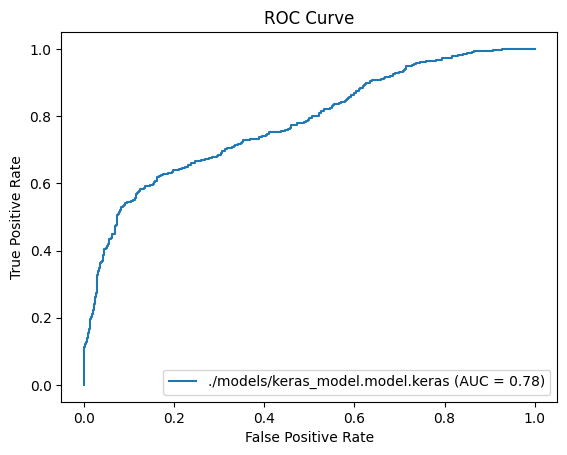

In [186]:
evaluate_keras_model(model, validation_generator, device, model_name)